In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = Path('/home/ilua/fastbook_week8_book13/archive/car parts')
absolute_path = path.resolve()
absolute_path

Path('/home/ilua/fastbook_week8_book13/archive/car parts')

In [4]:
for filename in os.listdir(path):
    file_path = path / filename
    if os.path.isfile(file_path):
        print(file_path)

/home/ilua/fastbook_week8_book13/archive/car parts/car parts.csv
/home/ilua/fastbook_week8_book13/archive/car parts/EfficientNetB2-40-(224 X 224)- 96.90.h5


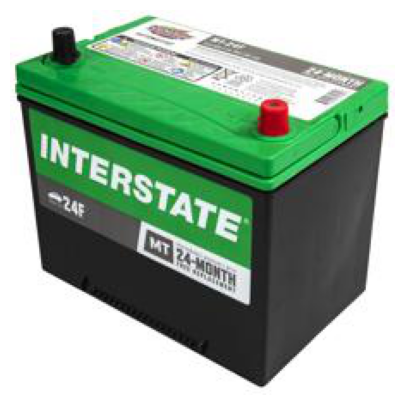

In [3]:
im3 = Image.open(path/'train'/'BATTERY'/'012.jpg')
show_image(im3);

In [4]:
mnist = DataBlock((ImageBlock(cls=PILImage), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 3, 224, 224])

In [8]:
yb

TensorCategory([20, 20, 20, 20, 20, 18, 18, 18, 18, 18,  8,  8,  8,  8,  8, 16, 16, 16, 16, 16, 14, 14, 14, 14, 14, 34, 34, 34, 34, 34,  4,  4,  4,  4,  4, 17, 17, 17, 17, 17, 23, 23, 23, 23, 23,  0,
                 0,  0,  0,  0, 24, 24, 24, 24, 24, 28, 28, 28, 28, 28, 26, 26, 26, 26], device='cuda:0')

In [15]:
xb.shape

torch.Size([64, 3, 224, 224])

In [5]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImage), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('train','test'),
        get_y=parent_label,
        # batch_tfms=Normalize()
        item_tfms=RandomResizedCrop(224, min_scale=0.5),
        batch_tfms=[*aug_transforms(), Normalize()]
    ).dataloaders(path, bs=bs)

dls = get_dls()

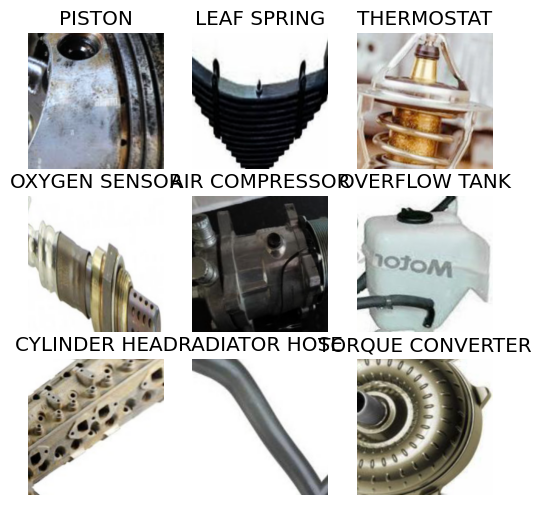

In [6]:
dls.show_batch(max_n=9, figsize=(6,6))

In [7]:
xb,yb = first(dls.valid)

In [8]:
yb

TensorCategory([20, 20, 20, 20, 20, 18, 18, 18, 18, 18,  8,  8,  8,  8,  8, 16, 16, 16, 16, 16, 14, 14, 14, 14, 14, 34, 34, 34, 34, 34,  4,  4,  4,  4,  4, 17, 17, 17, 17, 17, 23, 23, 23, 23, 23,  0,
                 0,  0,  0,  0, 24, 24, 24, 24, 24, 28, 28, 28, 28, 28, 26, 26, 26, 26], device='cuda:0')

In [9]:
xb.shape

torch.Size([64, 3, 224, 224])

In [12]:
xb_one = xb[7]

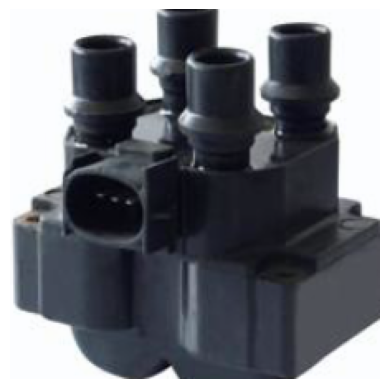

In [13]:
image = xb_one.permute(1, 2, 0)
# Normalize pixel values to [0, 1]
image = (image - image.min()) / (image.max() - image.min())
image = image.to('cpu')

# Clip values to [0, 1]
image = np.clip(image, 0, 1)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [68]:
def conv(ni, nf, ks=5, act=True):
    # res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: res = layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [69]:
# input 224x224
def simple_cnn():
    return sequential(
        conv(3 ,16, ks=7),        #112x112
        conv(16 ,32),             #56x56
        conv(32,64),              #28x28
        conv(64,64),              #14x14
        Flatten(),
        nn.Linear(64 * 14 * 14, 50),  #1x1
        
    )

In [48]:
from fastai.callback.hook import *

In [70]:
def fit(epochs=1, lr=0.03):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [54]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,108.929916,3.711160,0.025000,00:15


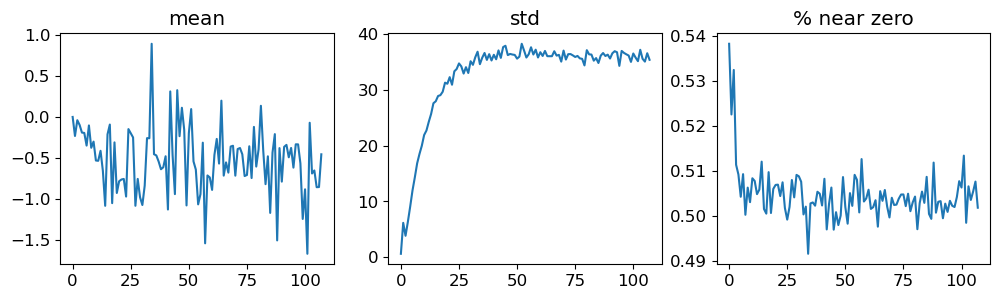

In [55]:
learn.activation_stats.plot_layer_stats(0)

In [56]:
dls = get_dls(128)

In [73]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,45.162022,1436.126587,0.045000,00:23


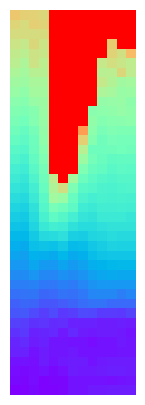

In [74]:
matplotlib.rcParams['image.cmap'] = 'rainbow_r'
learn.activation_stats.color_dim(-4)

In [75]:
learn = fit(10, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,20.371778,1736.162842,0.010000,00:23
1,25.939579,92.289688,0.085000,00:23
2,21.610214,28.819736,0.120000,00:24
3,22.433535,31.301184,0.115000,00:23
4,19.866114,12.861523,0.100000,00:23
5,17.868763,9.801502,0.115000,00:23
6,14.219075,4.238381,0.220000,00:24
7,11.242415,3.248152,0.265000,00:24
8,8.979398,2.991435,0.310000,00:23
9,7.305263,2.875755,0.295000,00:23


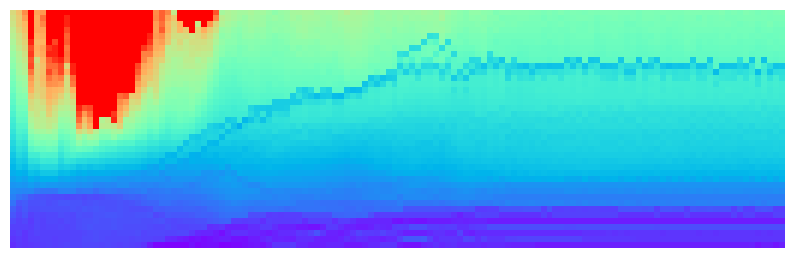

In [76]:
learn.activation_stats.color_dim(-4)

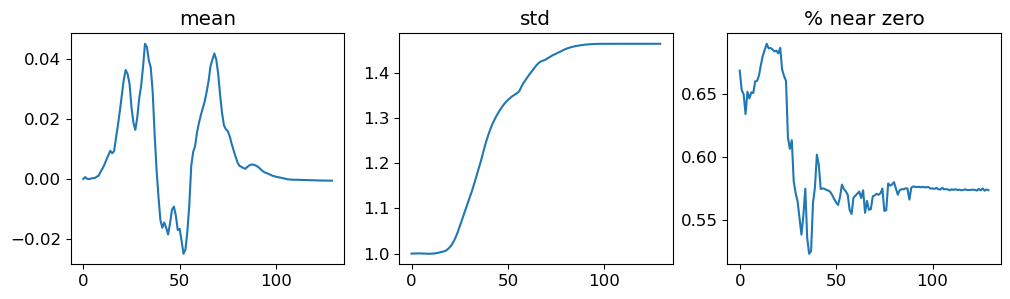

In [77]:
learn.activation_stats.plot_layer_stats(-4)

In [6]:
def conv2(ni, nf, ks=3, act=True):
    # res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: res = layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)
    
# input 224x224
def simple_cnn_v02():
    return sequential(
        conv2(3 ,32, ks=5),        #112x112
        nn.Dropout(0.2),
        conv2(32 ,48),             #56x56
        nn.Dropout(0.2),
        conv2(48,64),              #28x28
        nn.Dropout(0.3),
        conv2(64,128),              #14x14
        Flatten(),
        nn.Dropout(0.3),
        nn.Linear(128 * 14 * 14, 50),  #1x1
        
    )

In [94]:
def fit(epochs=1, lr=0.03):
    learn = Learner(dls, simple_cnn_v02(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

SuggestedLRs(valley=0.0008317637839354575)

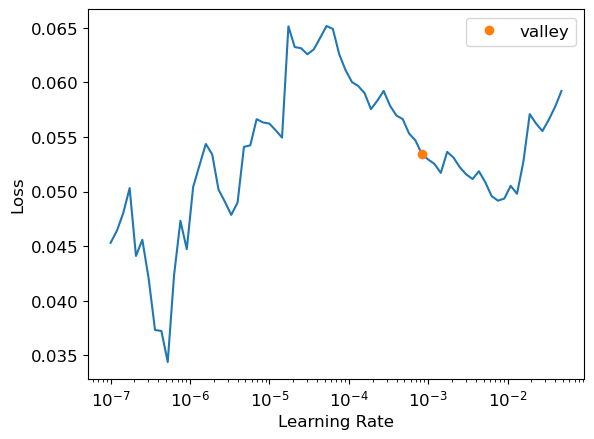

In [90]:
learn.lr_find()

In [9]:
dls = get_dls(64)

In [95]:
learn = fit(10, lr=0.0008)

epoch,train_loss,valid_loss,accuracy,time
0,2.970473,2.985110,0.245000,00:44
1,2.287847,2.848745,0.340000,00:44
2,1.823280,2.989020,0.380000,00:44
3,0.974653,2.758913,0.435000,00:44
4,0.489526,3.014356,0.470000,00:44
5,0.212538,2.964865,0.495000,00:44
6,0.107985,2.822742,0.485000,00:44
7,0.051489,2.852781,0.505000,00:44
8,0.031772,2.883854,0.500000,00:44
9,0.021152,2.852523,0.505000,00:45


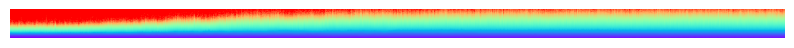

In [102]:
learn.activation_stats.color_dim(2)

In [10]:
def simple_cnn_v03():
    return sequential(
        nn.Conv2d(3, 64, 4, stride=1, padding=1), # Output is 64x225x225.
        nn.ReLU(),
        # nn.Dropout(0.2),
        nn.Conv2d(64, 64, 2, stride=2, padding=1), # Output is 64x112x112.
        nn.ReLU(),
        # nn.Dropout(0.2),
        nn.Conv2d(64, 32, 3, stride=2, padding=1), # Output is 32x56x56.
        nn.ReLU(),
        # nn.Dropout(0.2),
        nn.Conv2d(32, 32, 3, stride=2, padding=1), # Output is 32x28x28.
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Output is 32x14x14.
        nn.Flatten(),
        nn.Linear(32 * 14 * 14, 64),
        nn.ReLU(),
        # nn.Dropout(0.2),
        # nn.Linear(64, 64),
        # nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 50)
    )

In [117]:
def fit(epochs=1, lr=0.03):
    learn = Learner(dls, simple_cnn_v02(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

SuggestedLRs(valley=1.2022644114040304e-05)

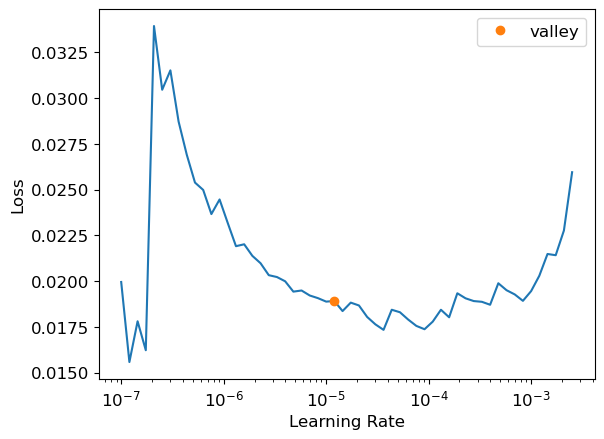

In [106]:
learn.lr_find()

In [108]:
learn = fit(10, lr=1.0e-03)

epoch,train_loss,valid_loss,accuracy,time
0,2.959966,2.723473,0.300000,00:47
1,2.370578,3.272391,0.295000,00:47
2,1.965587,2.894284,0.365000,00:46
3,1.015451,3.452775,0.375000,00:47
4,0.480633,3.165901,0.465000,00:48
5,0.232885,3.241429,0.445000,00:47
6,0.122014,3.391428,0.465000,00:48
7,0.059812,3.084006,0.480000,00:47
8,0.030608,3.009794,0.500000,00:47
9,0.019514,3.006465,0.485000,00:47


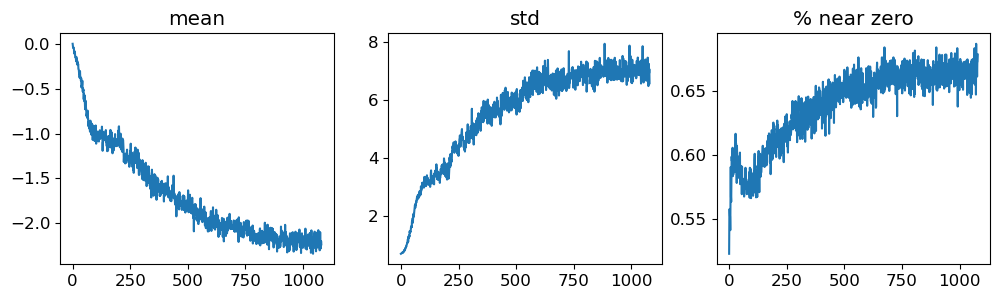

In [109]:
learn.activation_stats.plot_layer_stats(-1)

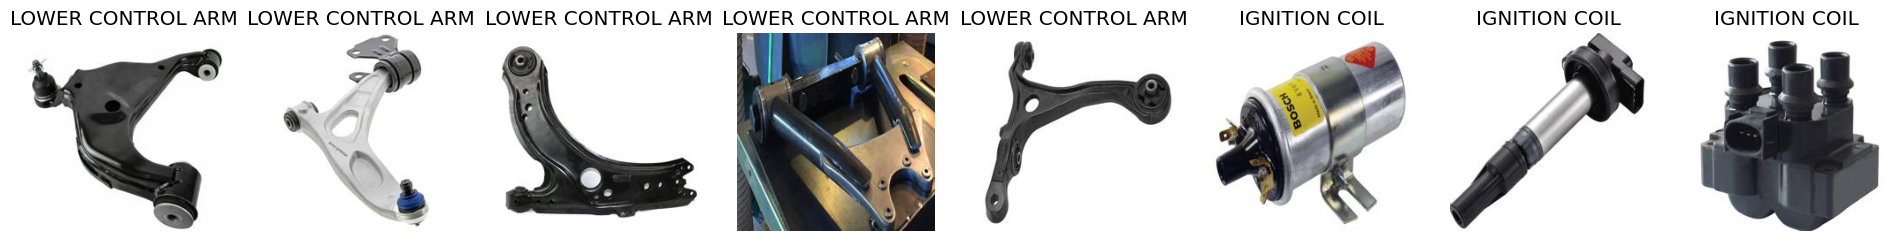

In [114]:
dls.valid.show_batch(max_n=8, nrows=1)

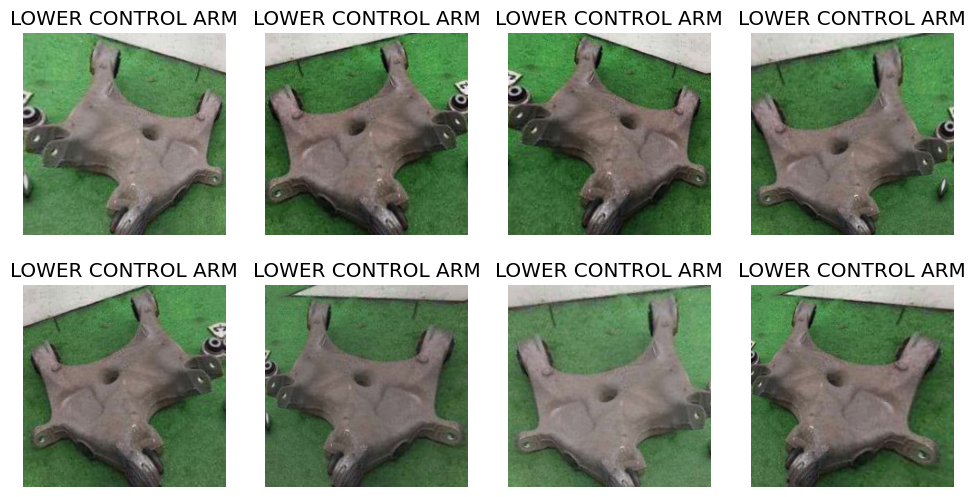

In [115]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

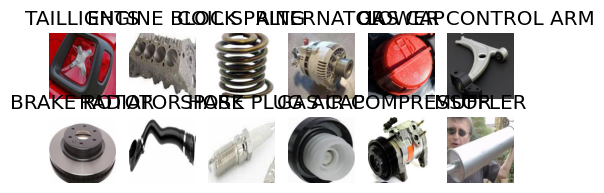

In [26]:
dls.show_batch(max_n=12, nrows=2,  figsize=(6,2))

In [124]:
learn = fit(10, lr=1.0e-04)

epoch,train_loss,valid_loss,accuracy,time
0,3.809019,3.444801,0.110000,00:47
1,3.125349,2.999494,0.190000,00:47
2,2.596403,2.593175,0.300000,00:46
3,2.349542,2.288280,0.390000,00:44
4,2.177713,2.200678,0.390000,00:44
5,2.041903,2.127287,0.420000,00:44
6,1.925396,2.000985,0.445000,00:44
7,1.866712,2.014338,0.450000,00:45
8,1.823133,1.982645,0.460000,00:45
9,1.800929,1.992792,0.465000,00:45


In [8]:
def fit(epochs=1, lr=0.03):
    learn = Learner(dls, simple_cnn_v03(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [33]:
learn = fit(3, lr=0.0005)

epoch,train_loss,valid_loss,accuracy,time
0,3.686477,3.423833,0.100000,02:00
1,3.306708,2.994836,0.195000,02:02
2,3.039396,2.796057,0.285000,02:01


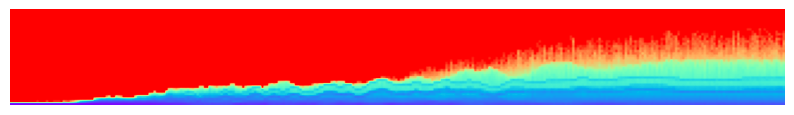

In [34]:
matplotlib.rcParams['image.cmap'] = 'rainbow_r'
learn.activation_stats.color_dim(3)

In [ ]:
def conv2(ni, nf, ks=3, act=True):
    # res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: res = layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)
    
# input 224x224
def simple_cnn_v04():
    return sequential(
        conv2(3 ,32, ks=5),        #112x112
        nn.Dropout(0.2),
        conv2(32 ,48),             #56x56
        nn.Dropout(0.2),
        conv2(48,64),              #28x28
        nn.Dropout(0.3),
        conv2(64,128),              #14x14
        Flatten(),
        nn.Dropout(0.2),
        nn.Linear(128 * 14 * 14, 128),  #128
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 50),             #50
    )

In [7]:
dls = get_dls(128)

In [20]:
def fit(epochs=1, lr=0.03):
    learn = Learner(dls, simple_cnn_v04(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [14]:
learn = fit(20, lr=0.00025)

epoch,train_loss,valid_loss,accuracy,time
0,3.790654,3.704983,0.085000,00:44
1,3.367800,3.271886,0.145000,00:45
2,2.959264,2.809966,0.275000,00:45
3,2.730350,2.458010,0.350000,00:44
4,2.521753,2.225486,0.405000,00:45
5,2.397004,2.061819,0.465000,00:45
6,2.268440,1.872926,0.460000,00:45
7,2.174524,1.819463,0.450000,00:46
8,2.048739,1.689247,0.580000,00:46
9,1.955021,1.729579,0.505000,00:46


In [25]:
torch.cuda.empty_cache()

In [21]:
learn = fit(20, lr=0.0005)

epoch,train_loss,valid_loss,accuracy,time
0,3.766909,3.598267,0.105000,00:46
1,3.438124,3.038356,0.220000,00:46
2,3.071565,2.555539,0.310000,00:46
3,2.791934,2.436790,0.355000,00:46
4,2.597791,2.093265,0.440000,00:48
5,2.409598,2.019267,0.410000,00:47
6,2.239365,1.829778,0.470000,00:46
7,2.103710,1.758658,0.490000,00:48
8,2.004376,1.619386,0.540000,00:48
9,1.904972,1.556616,0.535000,00:48


In [22]:
from fastai.callback.hook import *

def conv2(ni, nf, ks=3, act=True, stride=2):
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)]
    if act: res = layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)
    
# input 224x224
def simple_cnn_v04():
    return sequential(
        conv2(3 ,64, ks=5),        #112x112
        nn.Dropout(0.15),
        conv2(64 ,128),             #56x56
        nn.Dropout(0.15),
        conv2(128,128),              #28x28
        nn.Dropout(0.15),
        conv2(128,64, stride=1),              #28x28
        nn.Dropout(0.15),
        conv2(64,32),              #14x14
        nn.Dropout(0.15),
        conv2(32,32),              #7x7
        Flatten(),
        nn.Dropout(0.15),
        nn.Linear(32 * 7 * 7, 64),  #64
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Linear(64, 50),             #50
    )

In [11]:
def fit(epochs=1, lr=0.03):
    learn = Learner(dls, simple_cnn_v04(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [23]:
learn = Learner(dls, simple_cnn_v04(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
learn.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 112 x 11 
Conv2d                                    4864       True      
ReLU                                                           
BatchNorm2d                               128        True      
Dropout                                                        
____________________________________________________________________________
                     128 x 128 x 56 x 56 
Conv2d                                    73856      True      
ReLU                                                           
BatchNorm2d                               256        True      
Dropout                                                        
____________________________________________________________________________
                     128 x 128 x 28 x 28 
Conv2d                                    147584     True      
ReLU                              

In [24]:
learn = fit(30, lr=0.0006)

epoch,train_loss,valid_loss,accuracy,time
0,3.939861,3.899953,0.045000,01:20
1,3.877705,3.742322,0.055000,01:21
2,3.731068,3.482520,0.105000,01:20
3,3.432923,2.974032,0.200000,01:21
4,3.141283,2.705591,0.265000,01:21
5,2.901626,2.744253,0.250000,01:24
6,2.701476,2.283511,0.405000,01:23
7,2.534863,2.278071,0.360000,01:25
8,2.383812,2.010764,0.480000,01:24
9,2.245062,1.996097,0.445000,01:24


In [60]:
matplotlib.rcParams['image.cmap'] = 'rainbow_r'

In [62]:
learn.activation_stats.color_dim(0)

RuntimeError: stack expects a non-empty TensorList

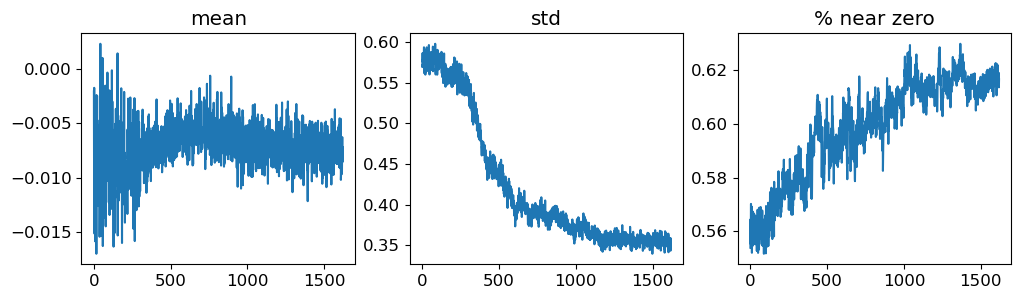

In [25]:
learn.activation_stats.plot_layer_stats(0)

In [31]:
torch.cuda.empty_cache()

In [46]:
btn_upload = SimpleNamespace(data = ['/home/ilua/fastbook_week8_book13/archive/car parts/valid/BATTERY/3.jpg'])

In [47]:
btn_upload

namespace(data=['/home/ilua/fastbook_week8_book13/archive/car parts/valid/BATTERY/3.jpg'])

In [48]:
img = PILImage.create(btn_upload.data[-1])

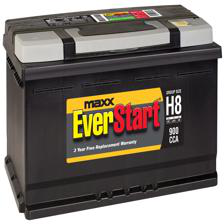

In [49]:
img

In [50]:
pred,pred_idx,probs = learn.predict(img)

In [52]:
pred

"['VACUUM BRAKE BOOSTER', 'VALVE LIFTER', 'COIL SPRING', 'ALTERNATOR', 'WATER PUMP', 'VALVE LIFTER', 'TRANSMISSION', 'TAILLIGHTS', 'BRAKE CALIPER', 'TRANSMISSION', 'TRANSMISSION', 'VALVE LIFTER', 'WATER PUMP', 'WATER PUMP', 'AIR COMPRESSOR', 'BATTERY', 'AIR COMPRESSOR', 'VACUUM BRAKE BOOSTER', 'AIR COMPRESSOR', 'AIR COMPRESSOR', 'AIR COMPRESSOR', 'VACUUM BRAKE BOOSTER', 'BRAKE CALIPER', 'ALTERNATOR', 'VALVE LIFTER', 'THERMOSTAT', 'WATER PUMP', 'ALTERNATOR', 'ALTERNATOR', 'VALVE LIFTER', 'AIR COMPRESSOR', 'AIR COMPRESSOR', 'THERMOSTAT', 'BATTERY', 'VALVE LIFTER', 'WATER PUMP', 'VACUUM BRAKE BOOSTER', 'VALVE LIFTER', 'TORQUE CONVERTER', 'VALVE LIFTER', 'RADIATOR FAN', 'RADIATOR FAN', 'SPARK PLUG', 'RADIATOR HOSE', 'RADIATOR HOSE', 'SPARK PLUG', 'SPARK PLUG', 'RIM', 'RIM', 'RADIATOR HOSE']"

In [53]:
pred_idx

tensor([ -3.6585,  -2.5315,   8.5450,   1.5405,  -1.5937,  -2.4061,  -4.2221,  -7.3448,   3.3454,  -4.1907,  -4.0716,  -2.4836,  -1.9761,  -1.8883,   0.2744,   2.3987,  -0.2287,  -3.9891,  -0.1938,
         -0.5960,   0.1111,  -3.2892,   3.4220,   1.5818,  -2.4549,  -6.0852,  -1.0467,   1.2629,   1.5674,  -2.5273,   0.9063,  -0.4991,  -6.3635,   2.0099,  -2.0593,  -1.9138,  -3.3911,  -2.8931,
         -5.8488,  -2.5518, -12.2561, -12.6715,  -9.4387, -11.8379, -11.0910,  -9.5121,  -9.3460, -10.8897, -10.1102, -11.0789])

In [56]:
probs

tensor([ -3.6585,  -2.5315,   8.5450,   1.5405,  -1.5937,  -2.4061,  -4.2221,  -7.3448,   3.3454,  -4.1907,  -4.0716,  -2.4836,  -1.9761,  -1.8883,   0.2744,   2.3987,  -0.2287,  -3.9891,  -0.1938,
         -0.5960,   0.1111,  -3.2892,   3.4220,   1.5818,  -2.4549,  -6.0852,  -1.0467,   1.2629,   1.5674,  -2.5273,   0.9063,  -0.4991,  -6.3635,   2.0099,  -2.0593,  -1.9138,  -3.3911,  -2.8931,
         -5.8488,  -2.5518, -12.2561, -12.6715,  -9.4387, -11.8379, -11.0910,  -9.5121,  -9.3460, -10.8897, -10.1102, -11.0789])

In [63]:
interp = ClassificationInterpretation.from_learner(learn)

# Fixed loss func here :

In [7]:
dls = get_dls(128)

In [4]:
trn_path = path/'train'
val_path = path/'valid'

In [5]:
dls = ImageDataLoaders.from_folder(
    trn_path, 
    valid_pct=0.2,   
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=256
)


In [6]:
from fastai.callback.hook import *

def conv2(ni, nf, ks=3, act=True, stride=2):
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)]
    if act: res = layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)
    
# input 224x224
def simple_cnn_v05():
    return sequential(
        conv2(3 ,64, ks=5),        #112x112
        conv2(64 ,128),             #56x56
        conv2(128,128),              #28x28
        conv2(128,64, stride=1),              #28x28
        conv2(64,32),              #14x14
        conv2(32,32),              #7x7
        Flatten(),
        nn.Linear(32 * 7 * 7, 64),  #64
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(64, 50),             #50
        # nn.Softmax(dim=1)
    )

In [7]:
def fit(epochs=1, lr=0.03):
    learn = Learner(dls, simple_cnn_v05(), loss_func=CrossEntropyLossFlat(),
                    metrics=accuracy, cbs=ActivationStats(with_hist=True)).to_fp16()
    learn.fit_one_cycle(epochs, lr)
    return learn

In [66]:
learn = fit(6, lr=0.001)

/home/ilua/miniconda3/lib/python3.11/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,3.906738,3.882910,0.080983,01:12
1,3.869373,3.818770,0.123644,01:14
2,3.832133,3.794606,0.150398,01:12
3,3.808634,3.756777,0.189443,01:12
4,3.785659,3.758307,0.190889,01:14
5,3.775233,3.748863,0.198120,01:13


SuggestedLRs(valley=0.0010000000474974513)

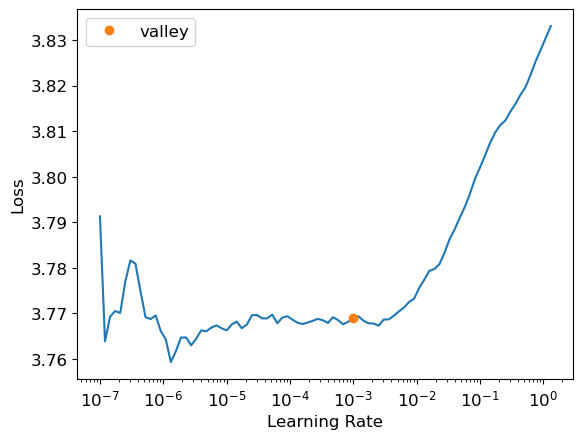

In [74]:
learn.lr_find()

In [8]:
learn = fit(25, lr=0.0011)

/home/ilua/miniconda3/lib/python3.11/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,3.939875,3.918568,0.009400,01:14
1,3.872186,3.715245,0.081706,01:13
2,3.725085,3.286944,0.106291,01:12
3,3.509191,3.018495,0.185105,01:12
4,3.276706,2.582629,0.292119,01:13
5,3.066956,2.413304,0.336949,01:15
6,2.887948,2.493283,0.328995,01:15
7,2.724297,2.150528,0.391179,01:15
8,2.571888,2.095412,0.427332,01:16
9,2.432471,1.958845,0.450470,01:14


In [9]:
tst_files = get_image_files(path/'test')

In [10]:
tst_dl = dls.test_dl(tst_files)

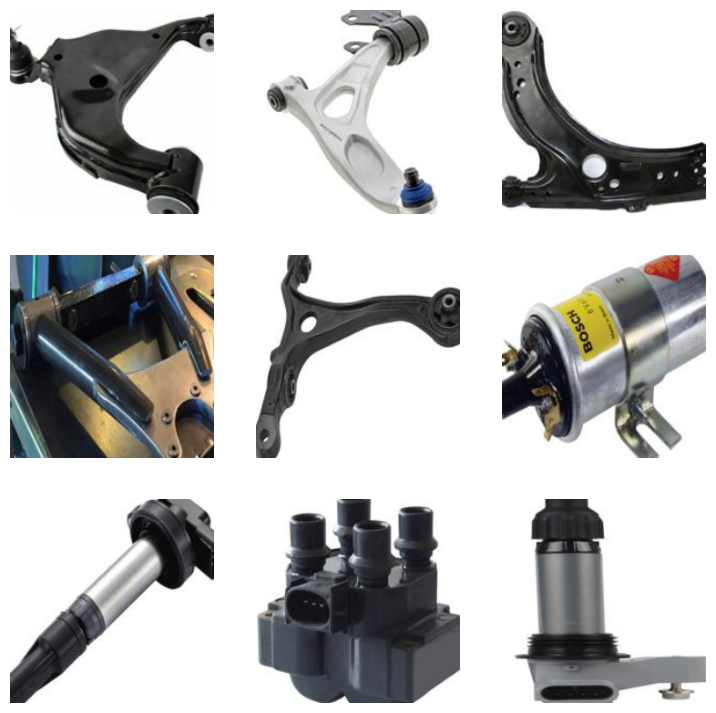

In [11]:
tst_dl.show_batch()

In [12]:
preds = learn.get_preds(dl=tst_dl, with_decoded=True)

In [13]:
probs,_,idxs = preds

In [14]:
idxs

tensor([20, 11, 19,  2, 17, 32, 13, 37, 13, 37,  8, 16,  8,  8,  8, 16, 16, 21, 16, 16, 14, 14, 28, 36, 14, 34, 34, 35, 34, 34,  4,  4, 27,  4, 31, 17, 21, 13, 17, 17, 28, 23, 21,  2, 22,  9,  0,  0,
        25,  0, 24, 24,  0, 24, 24, 28, 28, 28, 27, 30, 26, 20, 26, 27, 17, 34, 39, 32, 12,  7,  1, 12, 10, 12, 10, 15, 15, 16, 15, 15, 30, 28, 30, 30, 30, 38, 25, 38, 38, 38, 15,  2, 22, 22, 16, 19,
        28, 25, 29, 20, 33, 33, 33, 33,  2, 27, 27, 27, 27, 27, 21, 25, 31, 25, 37, 35, 25,  5,  5,  3,  3,  3,  3, 14,  3,  9,  9,  9, 36,  9,  9,  6, 37,  6,  6,  7,  7,  7,  7,  7, 23, 32, 31, 31,
        31,  1, 31, 11,  7,  2, 29, 29,  5, 21,  4, 32, 32, 11, 32, 32, 13, 18, 13, 13, 13, 30,  2,  2,  2,  2, 12, 12, 12, 12, 12, 39,  1,  1,  1, 12, 31, 34, 31, 31, 31, 18,  7, 15, 18, 35, 35, 35,
        35, 35, 35, 36,  9, 36, 36, 36])

In [15]:
dls.vocab

['AIR COMPRESSOR', 'ALTERNATOR', 'BATTERY', 'BRAKE CALIPER', 'BRAKE PAD', 'BRAKE ROTOR', 'CAMSHAFT', 'CARBERATOR', 'COIL SPRING', 'CRANKSHAFT', 'CYLINDER HEAD', 'DISTRIBUTOR', 'ENGINE BLOCK', 'FUEL INJECTOR', 'FUSE BOX', 'GAS CAP', 'HEADLIGHTS', 'IDLER ARM', 'IGNITION COIL', 'LEAF SPRING', 'LOWER CONTROL ARM', 'MUFFLER', 'OIL FILTER', 'OIL PAN', 'OVERFLOW TANK', 'OXYGEN SENSOR', 'PISTON', 'RADIATOR', 'RADIATOR FAN', 'RADIATOR HOSE', 'RIM', 'SPARK PLUG', 'STARTER', 'TAILLIGHTS', 'THERMOSTAT', 'TORQUE CONVERTER', 'TRANSMISSION', 'VACUUM BRAKE BOOSTER', 'VALVE LIFTER', 'WATER PUMP']

In [56]:
idxsnew

0      13
1      24
2      17
3      14
4      29
       ..
195     1
196    14
197    35
198    17
199    28
Name: indexes, Length: 200, dtype: int64

In [58]:
mapping = {k:v for k,v in enumerate(dls.vocab)}

In [60]:
res = idxsnew.map(mapping)

In [63]:
tst_dl.

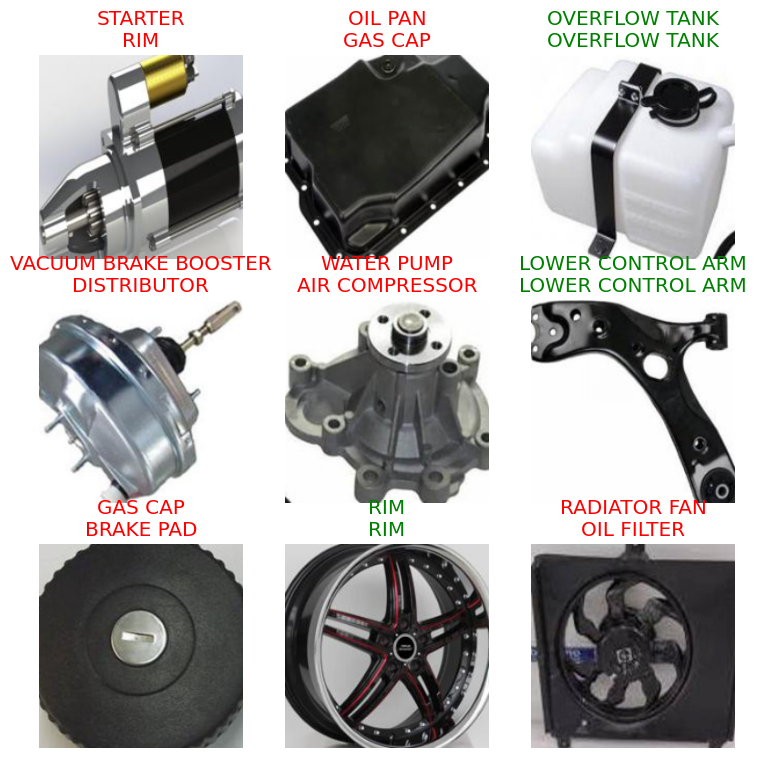

In [18]:
learn.show_results()